In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
from tqdm.notebook import tqdm

In [8]:
import random 
random.seed(42)

In [9]:
import pandas as pd

df = pd.read_csv('/kaggle/input/us-baby-names-by-year-of-birth/babyNamesUSYOB-mostpopular.csv')
names = df.Name.values

In [10]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{1: 'A',
 2: 'B',
 3: 'C',
 4: 'D',
 5: 'E',
 6: 'F',
 7: 'G',
 8: 'H',
 9: 'I',
 10: 'J',
 11: 'K',
 12: 'L',
 13: 'M',
 14: 'N',
 15: 'O',
 16: 'P',
 17: 'Q',
 18: 'R',
 19: 'S',
 20: 'T',
 21: 'U',
 22: 'V',
 23: 'W',
 24: 'X',
 25: 'Y',
 26: 'Z',
 27: 'a',
 28: 'b',
 29: 'c',
 30: 'd',
 31: 'e',
 32: 'f',
 33: 'g',
 34: 'h',
 35: 'i',
 36: 'j',
 37: 'k',
 38: 'l',
 39: 'm',
 40: 'n',
 41: 'o',
 42: 'p',
 43: 'q',
 44: 'r',
 45: 's',
 46: 't',
 47: 'u',
 48: 'v',
 49: 'w',
 50: 'x',
 51: 'y',
 52: 'z',
 0: '.'}

In [11]:
block_size = 8 # context length: how many characters taken to predict the next character

In [12]:
def build_dataset(words):
    X, Y = [], []
    for n in words:
    
        context = [0] * block_size
        for ch in n + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
        
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [13]:
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

# Train, Dev, and Test split 

Xtr, Ytr = build_dataset(names[:n1])          # 80%
Xdev, Ydev = build_dataset(names[n1:n2])      # 10%
Xte, Yte = build_dataset(names[n2:])          # 10%

torch.Size([1233618, 8]) torch.Size([1233618])
torch.Size([154343, 8]) torch.Size([154343])
torch.Size([154741, 8]) torch.Size([154741])


In [14]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> J
.......J --> o
......Jo --> n
.....Jon --> e
....Jone --> l
...Jonel --> l
..Jonell --> e
.Jonelle --> .
........ --> S
.......S --> a
......Sa --> m
.....Sam --> .
........ --> P
.......P --> a
......Pa --> t
.....Pat --> r
....Patr --> i
...Patri --> c
..Patric --> i
.Patrici --> a


In [15]:
# -----------------------------------------------------------------------------------------------
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [16]:
torch.manual_seed(42); # seed for reproducibility

### original network
```python
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 300 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])
```

In [17]:
# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

80557


In [18]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in tqdm(range(max_steps)):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  0%|          | 0/200000 [00:00<?, ?it/s]

      0/ 200000: 3.9578
  10000/ 200000: 1.5632
  20000/ 200000: 1.6911
  30000/ 200000: 1.1581
  40000/ 200000: 1.5555
  50000/ 200000: 1.4941
  60000/ 200000: 1.6560
  70000/ 200000: 1.1620
  80000/ 200000: 1.2137
  90000/ 200000: 1.4771
 100000/ 200000: 1.6984
 110000/ 200000: 1.0635
 120000/ 200000: 1.4136
 130000/ 200000: 1.3227
 140000/ 200000: 1.1537
 150000/ 200000: 1.4237
 160000/ 200000: 1.2930
 170000/ 200000: 1.4256
 180000/ 200000: 1.4653
 190000/ 200000: 1.1291


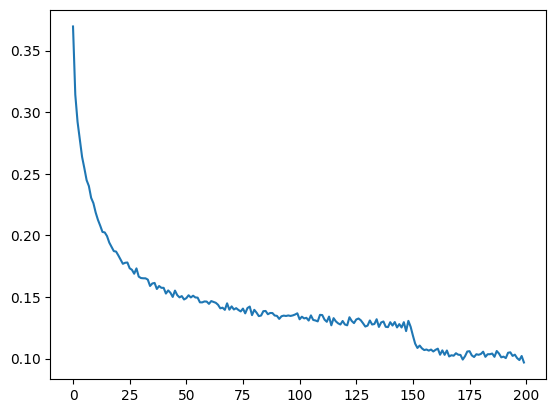

In [19]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [20]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [21]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.2576614618301392
val 1.2666233777999878


In [23]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

Ayesha.
Ashanti.
Allyson.
Davis.
Luis.
Gloria.
Deloris.
Marianna.
Addie.
Louie.
Gilberto.
Noelia.
Eli.
Dione.
Carolina.
Edmond.
Anna.
Pedro.
Fredric.
Leila.
